# Causal Analysis of Synthetic Dataset

In [34]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import random
import seaborn as sns
from pymatch.Matcher import Matcher
from pymatch.functions import ks_boot
from joblib import Parallel, delayed

from utils import treatment_effect

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT_COL = 'ContinentOfBirth'
#TREATMENT_COL = 'CitizenshipContinent'
TREATMENT_VAL = 'Asia'
treatment_subdimensions = ['CitizenshipCountry'] if TREATMENT_COL == 'CitizenshipContinent' else ['CountryOfBirth']

OUTCOME_NAME = 'Last Name Correct'

TREATMENT = 'T'
OUTCOME = 'O'

In [35]:
dataset = pd.read_csv('data/synthetic-dataset-scenario-B.csv')
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'Last Name Correct'],
      dtype='object')

In [36]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset[TREATMENT] = dataset[TREATMENT_COL] == TREATMENT_VAL
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)
dataset.head()

COVARIATES = dataset.drop([TREATMENT, OUTCOME, TREATMENT_COL, 'Last Name'] + treatment_subdimensions, axis=1).columns.values
CONT_COVARIATES = ['NumChildren']
CAT_COVARIATES = list(c for c in COVARIATES if c not in CONT_COVARIATES)

## Analysis with Matching and Propensity Score Stratification

In [37]:
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'O', 'T'],
      dtype='object')

In [38]:
match_vars = ['CitizenshipContinent'] if TREATMENT_COL == 'ContinentOfBirth' else ['ContinentOfBirth']
att = treatment_effect.match_then_stratify(dataset, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions,
                                           OUTCOME, CONT_COVARIATES, CAT_COVARIATES, additional_excludes=['Last Name'])
#att = treatment_effect.match_exactly(dataset.copy(), TREATMENT, TREATMENT_COL, treatment_subdimensions, OUTCOME, exclude_vars=['Last Name', 'NumChildren'])
att

Training model 1/50
Training model 2/50
Training model 3/50
Training model 4/50
Training model 5/50
Training model 6/50
Training model 7/50
Training model 8/50
Training model 9/50
Training model 10/50
Training model 11/50
Training model 12/50
Training model 13/50
Training model 14/50
Training model 15/50
Training model 16/50
Training model 17/50
Training model 18/50
Training model 19/50
Training model 20/50
Training model 21/50
Training model 22/50
Training model 23/50
Training model 24/50
Training model 25/50
Training model 26/50
Training model 27/50
Training model 28/50
Training model 29/50
Training model 30/50
Training model 31/50
Training model 32/50
Training model 33/50
Training model 34/50
Training model 35/50
Training model 36/50
Training model 37/50
Training model 38/50
Training model 39/50
Training model 40/50
Training model 41/50
Training model 42/50
Training model 43/50
Training model 44/50
Training model 45/50
Training model 46/50
Training model 47/50
Training model 48/50
T

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Training model 1/50
Training model 2/50
Training model 3/50
Training model 4/50
Training model 5/50
Training model 6/50
Training model 7/50
Training model 8/50
Training model 9/50
Training model 10/50
Training model 11/50
Training model 12/50
Training model 13/50
Training model 14/50
Training model 15/50
Training model 16/50
Training model 17/50
Training model 18/50
Training model 19/50
Training model 20/50
Training model 21/50
Training model 22/50
Training model 23/50
Training model 24/50
Training model 25/50
Training model 26/50
Training model 27/50
Training model 28/50
Training model 29/50
Training model 30/50
Training model 31/50
Training model 32/50
Training model 33/50
Training model 34/50
Training model 35/50
Training model 36/50
Training model 37/50
Training model 38/50
Training model 39/50
Training model 40/50
Training model 41/50
Training model 42/50
Training model 43/50
Training model 44/50
Training model 45/50
Training model 46/50
Training model 47/50
Training model 48/50
T

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))



Training model 2/50
Training model 3/50
Training model 4/50
Training model 5/50
Training model 6/50
Training model 7/50
Training model 8/50
Training model 9/50
Training model 10/50
Training model 11/50
Training model 12/50
Training model 13/50
Training model 14/50
Training model 15/50
Training model 16/50
Training model 17/50
Training model 18/50
Training model 19/50
Training model 20/50
Training model 21/50
Training model 22/50
Training model 23/50
Training model 24/50
Training model 25/50
Training model 26/50
Training model 27/50
Training model 28/50
Training model 29/50
Training model 30/50
Training model 31/50
Training model 32/50
Training model 33/50
Training model 34/50
Training model 35/50
Training model 36/50
Training model 37/50
Training model 38/50
Training model 39/50
Training model 40/50
Training model 41/50
Training model 42/50
Training model 43/50
Training model 44/50
Training model 45/50
Training model 46/50
Training model 47/50
Training model 48/50
Training model 49/50

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


-0.14352971213704188

#### Get statistical significance by comparing with placebo treatment

In [39]:
n_iter = 50
placebo_results = treatment_effect.generate_placebo_effects(dataset, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions,
                                                            OUTCOME, CONT_COVARIATES, CAT_COVARIATES, additional_excludes=['Last Name'], n_iter=n_iter)

In [40]:
treatment_effect.check_treatment_effect(att, placebo_results)

Treatment effect outside 95%-bounds of placebo effect: -0.14352971213704188 not in [-0.012139767722712769, 0.00850848538962255]


In [41]:
treatment_results = Parallel(n_jobs=4)(delayed(treatment_effect.match_then_stratify)(dataset.sample(frac=1, replace=True), match_vars, TREATMENT, 
                                                                                     TREATMENT_COL, treatment_subdimensions, OUTCOME, CONT_COVARIATES, 
                                                                                     CAT_COVARIATES, additional_excludes=['Last Name'], n_models=2) for _ in  range(n_iter))
#treatment_results = Parallel(n_jobs=4)(delayed(treatment_effect.match_exactly)(dataset.sample(frac=.8, replace=False), TREATMENT, TREATMENT_COL, treatment_subdimensions, 
#                                                                               OUTCOME, exclude_vars=['Last Name', 'NumChildren']) for _ in  range(n_iter))

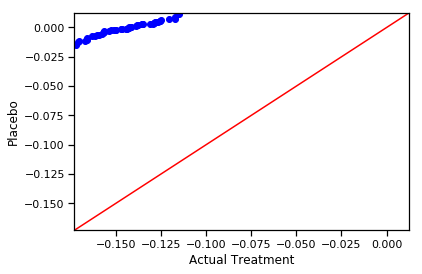

In [44]:
# QQ-Plot to compare empirical distributions.
from statsmodels.graphics.gofplots import qqplot_2samples
import pylab
import matplotlib.pyplot as plt

f = qqplot_2samples(np.array(placebo_results), np.array(treatment_results), xlabel='Actual Treatment', ylabel='Placebo', line='45')

plt.savefig("report/figures/qqBirth.pdf", bbox_inches='tight')

In [43]:
treatment_effect.ks_test_treatment_effect(placebo_results, treatment_results, n_iter, alpha=0.05)

Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: 1.00000, p-value: 2.16468817146063e-23)
